In [1]:
import pe_ode as pe
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint

# Test of Parameter Estimation methods for ODE model
## Model 1: Homogeneous gas phase reaction model
$$2NO+O_2\leftrightarrow2NO_2$$
is described by the following equation
$$\frac{dy}{dt}=k_1(126.2-y)(91.9-y)^2-k_2y^2;~~y(0)=0$$

In [2]:
def model1(y,k):
    dydt = k[0]*(126.2-y)*(91.9-y)**2-k[1]*y**2
    return dydt

## Model 2: Pyrolytic dehydrogenation model
Pyrolytic dehydrogenation of benzene to diphenyl and triphenyl
$$2C_2H_6\longleftrightarrow C_{12}H_{10}+H_2$$
$$C_6H_6+C_{12}H_{10}\longleftrightarrow C_{10}H_{14}+H_2$$
with differential equations model
\begin{align*}
\frac{dy_1}{dt}=&-r_1-r_2;~~y_1(0)=1\\
\frac{dy_2}{dt}=&\frac{r_1}{2}-r_2;~~~~y_2(0)=0\\
r_1=&k_1\left(y_1^2-y_2\frac{2-2y_1-y_2}{3K_1}\right)\\
r_2=&k_2\left(y_1y_2-\frac{(1-y_1-2y_2)(2-2y_1-y_2)}{9K_2}\right)
\end{align*}
with $K_1=0.242$ and $K_2=0.428$

In [3]:
def model2(y,k):
    K1 = 0.242
    K2 = 0.428
    r1 = k[0]*(y[0]**2-y[1]*(2-2*y[0]-y[1])/(3*K1))
    r2 = k[1]*(y[0]*y[1]-(1-y[0]-2*y[1])*(2-2*y[0]-y[1])/(9*K2))
    dydt = np.empty(2)
    dydt[0] = -r1-r2
    dydt[1] = r1/2-r2
    return dydt

## Jacobian
### Model 1
Differential equation $\frac{d\mathbf{J}}{dt}$ with $\mathbf{J}=\frac{\partial\mathbf{y}}{\partial\mathbf{k}}$ is
$$\frac{d\mathbf{J}}{dt}=\frac{\partial\mathbf{f}}{\partial\mathbf{y}}\mathbf{J}+\frac{\partial\mathbf{f}}{\partial\mathbf{k}}$$
For this model
$$\frac{\partial f}{\partial y}=-k_1(91.9-y)^2-2k_1(126.2-y)(91.9-y)-2k_2y$$
$$\frac{\partial f}{\partial k_1}=(126.2-y)(91.9-y)^2$$
$$\frac{\partial f}{\partial k_2}=-y^2$$

In [4]:
def model1_dfdy(y,k):
    dfdy = -k[0]*(91.9-y)**2-2*k[0]*(126.2-y)*(91.9-y)-2*k[1]*y
    return dfdy
def model1_dfdk(y,k):
    dfdk = np.empty(2)
    dfdk[0] = (126.2-y)*(91.9-y)**2
    dfdk[1] = -y**2
    return dfdk

### Model 2
\begin{align*}
r_1=&2y_1+\frac{2y_2}{3K_1}\\
r_2=&\frac{2y_1+2y_2-2}{3K_1}\\
r_3=&y_2-\frac{4y_1+5y_2-4}{9K_2}\\
r_4=&y_1-\frac{5y_1+4y_2-5}{9K_2}\\\\
\frac{\partial f_1}{\partial y_1}=&-k_1r_1-k_2r_3,\hspace{1cm}\frac{\partial f_1}{\partial y_2}=-k_1r_2-k_2r_4\\
\frac{\partial f_2}{\partial y_1}=&\frac{k_1}{2}r_1-k_2r_3,\hspace{1.3cm}\frac{\partial f_2}{\partial y_2}=\frac{k_1}{2}r_2-k_2r_4\\\\
\frac{\partial f_1}{\partial k_1}=&-\left(y_1^2+\frac{y_2^2+2y_1y_2-2y_2}{3K_1}\right)\\
\frac{\partial f_1}{\partial k_2}=&-\left(y_1y_2-\frac{2y_1^2-4y_1+5y_1y_2-5y_2+2y_2^2+2}{9K_2}\right)\\
\frac{\partial f_2}{\partial k_1}=&-\frac{1}{2}\frac{\partial f_1}{\partial k_1}\\
\frac{\partial f_2}{\partial k_2}=&\frac{\partial f_1}{\partial k_2}
\end{align*}

In [5]:
def model2_dfdy(y,k):
    K1 = 0.242
    K2 = 0.428
    r1 = 2*y[0]+2*y[1]/(3*K1)
    r2 = 2*(y[0]+y[1]-1)/(3*K1)
    r3 = y[1]-(4*y[0]+5*y[1]-4)/(9*K2)
    r4 = y[0]-(5*y[0]+4*y[1]-5)/(9*K2)
    dfdy = np.empty((2,2))
    dfdy[0,0] = -k[0]*r1-k[1]*r3
    dfdy[0,1] = -k[0]*r2-k[1]*r4
    dfdy[1,0] = k[0]*r1/2-k[1]*r3
    dfdy[1,1] = k[0]*r2/2-k[1]*r4
    return dfdy
def model2_dfdk(y,k):
    K1 = 0.242
    K2 = 0.428
    dfdk = np.empty((2,2))
    dfdk[0,0] = -(y[0]**2+(y[1]**2+2*y[0]*y[1]-2*y[1])/(3*K1))
    dfdk[0,1] = -(y[0]*y[1]-(2*y[0]**2-4*y[0]+5*y[0]*y[1]-5*y[1]+2*y[1]**2+2)/(9*K2))
    dfdk[1,0] = -dfdk[0,0]/2
    dfdk[1,1] = dfdk[0,1]
    return dfdk

## Comparison with numerical differentiation
Numerical differentiation by `pe_ode` functions and analytic results given above will be compared. 
### Model 1
Homogeneous gas model has 15 measurements and the parameter estimations are $k_1=0.4577\times10^{-5}$ and $k_2=0.2796\times10^{-3}$

In [6]:
yhat_model1=np.array([[0,1.4,6.3,10.5,14.2,17.6,21.4,23.0,27.0,30.5,34.4,38.8,41.6,43.5,45.3]])
t_model1 = np.array([0,1,2,3,4,5,6,7,9,11,14,19,24,29,39])
k_model1 = np.array([0.4577e-5,0.2796e-3])

In [7]:
dfdy_anal = np.empty(15)
dfdy_num = np.empty(15)
dfdk_anal = np.empty((2,15))
dfdk_num = np.empty((2,15))
y_temp = pe.state_only_int(model1,np.array([0]),k_model1,t_model1)
y_k_model1 = y_temp[0]
for i in range(15):
    dfdy_anal[i] = model1_dfdy(y_k_model1[:,i],k_model1)
    dfdy_num[i] = pe.dfdy_ode(model1,y_k_model1[:,i],k_model1,1)
    dfdk_anal[:,i] = model1_dfdk(y_k_model1[:,i],k_model1)
    dfdk_num[:,i] = pe.dfdk_ode(model1,y_k_model1[:,i],k_model1,1,2)
dfdy_diff = dfdy_anal-dfdy_num
dfdk_diff = dfdk_anal-dfdk_num
rel_dfdy = np.max(np.abs(dfdy_diff))/np.linalg.norm(dfdy_anal,np.inf)
rel_dfdk = np.max(np.abs(dfdk_diff))/np.linalg.norm(dfdk_anal,np.inf)
print('dfdy difference {0:1.2e} (inf norm)'.format(rel_dfdy))    
print('dfdk difference {0:1.2e} (inf norm)'.format(rel_dfdk))

dfdy difference 7.08e-07 (inf norm)
dfdk difference 7.64e-15 (inf norm)


### Model 2
Dehydrogenation model has eight measurements and the parameter estimations are $k_1=354.61$ and $k_2=400.23$

In [8]:
t_model2 = np.array([0,5.63,11.32,16.97,22.62,34.00,39.70,45.20,169.7],dtype='f')*1e-4
yhat_model2 = np.array([[1,0.828,0.704,0.622,0.565,0.499,0.482,0.470,0.443],
                   [0,0.0737,0.1130,0.1322,0.1400,0.1468,0.1477,0.1477,0.1476]],dtype='f')
y0_model2 = yhat_model2[:,0]
k_model2 = np.array([354.61,400.23])

In [9]:
k1000 = np.array([1000,1000],dtype='float64')
N_model2 = np.size(t_model2)
dfdy_model2_ana = np.empty((N_model2,2,2))
dfdy_model2_num = np.empty((N_model2,2,2))
dfdk_model2_ana = np.empty((N_model2,2,2))
dfdk_model2_num = np.empty((N_model2,2,2))
y1000,fasu = pe.state_only_int(model2,y0_model2,k1000,t_model2)
for i in range(N_model2):
    dfdy_model2_ana[i] = model2_dfdy(y1000[:,i],k1000)
    dfdy_model2_num[i] = pe.dfdy_ode(model2,y1000[:,i],k1000,2)
    dfdk_model2_ana[i] = model2_dfdk(y1000[:,i],k1000)
    dfdk_model2_num[i] = pe.dfdk_ode(model2,y1000[:,i],k1000,2,2)
dfdy_diff = dfdy_model2_ana-dfdy_model2_num
dfdk_diff = dfdk_model2_ana-dfdk_model2_num
rel_dfdy = np.linalg.norm(dfdy_diff)/np.linalg.norm(dfdy_model2_ana)
rel_dfdk = np.linalg.norm(dfdk_diff)/np.linalg.norm(dfdk_model2_ana)
print('dfdy difference {0:1.2e}'.format(rel_dfdy))
print('dfdk difference {0:1.2e}'.format(rel_dfdk))

dfdy difference 2.69e-09
dfdk difference 2.87e-06


## Test of $\varphi(\mathbf{z})$
### Model 1
With an initial condition $y_0=0$, $\mathbf{J}=\begin{bmatrix}0&0\end{bmatrix}$
$$\frac{dy}{dt}=4.577\times10^{-6}(126.2-0)(91.9-0)^2-2.796\times10^{-4}\times0^2=4.8783$$
$$\frac{\partial f}{\partial y}=-4.577\times10^{-6}(91.9-0)^2-2\times4.577\times10^{-6}(126.2-0)(91.9-0)-2\times2.796\times10^{-4}\times0=-0.1448$$
$$\frac{\partial f}{\partial k_1}=(126.2-0)(91.9-0)^2=1065836$$
$$\frac{\partial f}{\partial k_2}=-0^2=0$$
The differential equation for Jacobian is
$$\frac{d\mathbf{J}}{dt}=-0.1448\times\begin{bmatrix}0 & 0\end{bmatrix}+\begin{bmatrix}1065836&0\end{bmatrix}=\begin{bmatrix}1065836&0\end{bmatrix}$$

In [10]:
y_temp = 0
dfdy_model1_ana = model1_dfdy(y_temp,k_model1)
dfdk_model1_ana = model1_dfdk(y_temp,k_model1)
J_temp = np.array([0,0])
dJdt_model1_ana = dfdy_model1_ana*J_temp+dfdk_model1_ana
print('Analytic dJdt is ',dJdt_model1_ana)
z = np.empty(3)
z[0] = y_temp
z[1:] = J_temp
dJdt_model1_num = pe.phi_z(model1,z,k_model1,1,2)
print('Numerical dJdt is ',dJdt_model1_num[1:])

Analytic dJdt is  [1065835.982       0.   ]
Numerical dJdt is  [1065835.98199994       0.        ]


### Model 2
Artificial initial condition $y0=[5~~10]$ and $\mathbf{J}=\begin{bmatrix}
200&300\\
150&50\end{bmatrix}$
$$\frac{d\mathbf{J}}{dt}=\frac{\partial\mathbf{f}}{\partial\mathbf{y}}\mathbf{J}+\frac{\partial\mathbf{f}}{\partial\mathbf{k}}$$

In [11]:
y_model2_temp0 = np.array([5,10])
J_model2_temp = np.array([[200,300],[150,50]])
dfdy_model2_temp = model2_dfdy(y_model2_temp0,k_model2)
dfdk_model2_temp = model2_dfdk(y_model2_temp0,k_model2)
dJdt_model2_ana = np.matmul(dfdy_model2_temp,J_model2_temp)+dfdk_model2_temp
z_model2 = np.empty(6)
z_model2[0:2] = y_model2_temp0
z_model2[2:] = J_model2_temp.transpose().flatten()
dzdt_model2 = pe.phi_z(model2,z_model2,k_model2,2,2)
dJdt_model2_num = dzdt_model2[2:].reshape(2,2).transpose()
print('Analytic dJdt is \n',dJdt_model2_ana)
print('Numerical dJdt is \n',dJdt_model2_num)

Analytic dJdt is 
 [[-3508740.85315775 -3610034.82730877]
 [ 3563353.91956953  3407433.3131871 ]]
Numerical dJdt is 
 [[-3508741.33291654 -3610035.15135963]
 [ 3563354.37318194  3407433.77309991]]


In [12]:
y_model2_temp0 = np.array([1,0])
J_model2_temp = np.array([[0,0],[0,0]])
k_model2_guess = np.array([10000,10000])
dfdy_model2_temp = model2_dfdy(y_model2_temp0,k_model2_guess)
dfdk_model2_guess_temp = model2_dfdk(y_model2_temp0,k_model2_guess)
dJdt_model2_ana = np.matmul(dfdy_model2_temp,J_model2_temp)+dfdk_model2_guess_temp
z_model2 = np.empty(6)
z_model2[0:2] = y_model2_temp0
z_model2[2:] = J_model2_temp.transpose().flatten()
dzdt_model2 = pe.phi_z(model2,z_model2,k_model2_guess,2,2)
dJdt_model2_num = dzdt_model2[2:].reshape(2,2).transpose()
print('Analytic dJdt is \n',dJdt_model2_ana)
print('Numerical dJdt is \n',dJdt_model2_num)

Analytic dJdt is 
 [[-1.   0. ]
 [ 0.5  0. ]]
Numerical dJdt is 
 [[-1.00008037  0.        ]
 [ 0.50004019  0.        ]]


## Integration with estimated parameters
### Model 1

In [13]:
y0 = yhat_model1[:,0]
res_model1 = pe.state_jacob_int(model1,y0,k_model1,t_model1)

Jacobian
[[0. 0.]]
[[ 9.27370654e+05 -6.89875129e+00]]
[[ 1.63014749e+06 -4.84419743e+01]]
[[ 2.16757281e+06 -1.44611048e+02]]
[[ 2.58077504e+06 -3.05211321e+02]]
[[ 2.89900622e+06 -5.33798827e+02]]
[[ 3.14403358e+06 -8.30288775e+02]]
[[ 3.33115141e+06 -1.19188702e+03]]
[[ 3.57842540e+06 -2.09397023e+03]]
[[ 3.70681368e+06 -3.20044231e+03]]
[[3763593.48611649   -5150.32635678]]
[[3669696.49666203   -8853.71520985]]
[[3482142.95125699  -12718.05799824]]
[[3274617.8936603   -16431.03234524]]
[[2905273.18131808  -22776.51257757]]


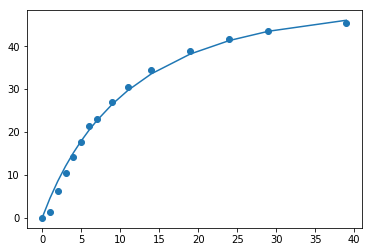

In [14]:
plt.clf()
plt.figure(1)
plt.scatter(t_model1,yhat_model1)
plt.plot(t_model1,res_model1[0][0,:])
print('Jacobian')
print(*res_model1[1],sep='\n')

In [15]:
N1 = 15
J_normal_y = np.zeros((N1,1,2))
for i in range(1,N1):
    J_normal_y[i] = res_model1[1][i]/res_model1[0][:,i]
print(*J_normal_y,sep='\n')
K1 = np.diag(k_model1)

[[0. 0.]]
[[ 2.03850240e+05 -1.51645094e+00]]
[[ 1.91239764e+05 -5.68294084e+00]]
[[ 1.80235874e+05 -1.20245551e+01]]
[[ 1.70529865e+05 -2.01674476e+01]]
[[ 1.61887954e+05 -2.98086976e+01]]
[[ 1.54146949e+05 -4.07077335e+01]]
[[ 1.47145782e+05 -5.26488068e+01]]
[[ 1.34993931e+05 -7.89937583e+01]]
[[ 1.24759970e+05 -1.07717064e+02]]
[[112117.89296547   -153.42882842]]
[[96071.44443225  -231.78734524]]
[[84253.25752026  -307.72367208]]
[[75300.52481657  -377.83503268]]
[[63077.70297514  -494.51118897]]


### Model 2

Jacobian
[[0. 0.]
 [0. 0.]]
[[-3.90267081e-04 -1.62685326e-05]
 [ 1.69437807e-04 -1.93878548e-05]]
[[-5.26574250e-04 -3.82839771e-05]
 [ 2.08403141e-04 -5.19365181e-05]]
[[-5.25552588e-04 -5.14564067e-05]
 [ 1.97280549e-04 -7.60591874e-05]]
[[-4.65126820e-04 -5.58872386e-05]
 [ 1.70508583e-04 -8.72084943e-05]]
[[-3.07581678e-04 -4.93449214e-05]
 [ 1.13525940e-04 -8.08521169e-05]]
[[-2.38931834e-04 -4.27692119e-05]
 [ 8.98380206e-05 -7.06632214e-05]]
[[-1.84061115e-04 -3.60878218e-05]
 [ 7.07467410e-05 -5.98401691e-05]]
[[-1.30737774e-07 -5.85794893e-08]
 [ 7.75995370e-08 -1.26581694e-07]]


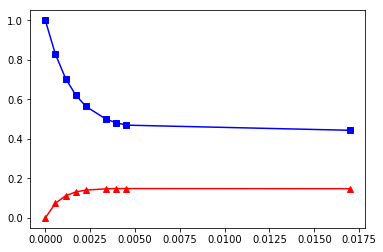

In [16]:
res_model2 = pe.state_jacob_int(model2,y0_model2,k_model2,t_model2)
plt.figure(2)
plt.plot(t_model2,yhat_model2[0,:],'bs',t_model2,yhat_model2[1,:],'r^')
plt.plot(t_model2,res_model2[0][0,:],'b',t_model2,res_model2[0][1,:],'r')
print('Jacobian')
print(*res_model2[1],sep='\n')

In [17]:
k0_model2 = np.array([1e4,1e4])
res_model2_guess = pe.state_jacob_int(model2,y0_model2,k0_model2,t_model2)
print('Jacobian')
print(*res_model2_guess[1],sep='\n')
sum = res_model2_guess[1][0]
for i in range(1,9):
    sum += res_model2_guess[1][i]
print(sum)

Jacobian
[[0. 0.]
 [0. 0.]]
[[-6.62515472e-09 -1.29206277e-08]
 [ 3.37533379e-09 -2.13929020e-08]]
[[-4.72899490e-11 -5.76980397e-11]
 [ 1.21700787e-11 -9.99656522e-11]]
[[ 1.62862363e-11  1.73084084e-11]
 [-4.05611031e-12  2.98050754e-11]]
[[-7.03178867e-12  2.26933607e-12]
 [-1.27993848e-11 -3.53131082e-12]]
[[ 4.06963287e-13 -2.37187984e-13]
 [ 7.54141058e-13  1.21194553e-13]]
[[ 2.04140498e-12 -8.11671351e-13]
 [ 3.80972217e-12  8.89097834e-13]]
[[ 2.61831544e-12 -1.01416036e-12]
 [ 4.93389455e-12  1.14942023e-12]]
[[-7.08942659e-15  5.76723447e-14]
 [-8.32483559e-14  6.15121288e-14]]
[[-6.65813063e-09 -1.29607534e-08]
 [ 3.38006288e-09 -2.14643726e-08]]


# Scaling
## Scaling of model1
$$2NO+O_2\leftrightarrow2NO_2$$
$$\frac{dy}{dt}=k_1(126.2-y)(91.9-y)^2-k_2y^2;~~y(0)=0$$
Unit of $y$ is $[M]$, $t$ is $[T]$, $k_1$ is $[M^{-2}T^{-1}]$, and $k_2$ is $[M^{-1}T^{-1}]$.
Insert $u=y/y_c$ and $\bar{t}=t/t_c$
$$\frac{y_c}{t_c}\frac{du}{d\bar{t}}=k_1(126.2-y_cu)(91.9-y_cu)^2-k_2y_c^2u^2$$
$$\frac{du}{d\bar{t}}=k_1\frac{t_c}{y_c}(126.2-y_cu)(91.9-y_cu)^2-t_ck_2y_cu^2$$
$$\frac{du}{d\bar{t}}=k_1t_cy_c^2(126.2/y_c-u)(91.9/y_c-u)^2-t_ck_2y_cu^2$$
Let $y_c=91.9$ and $t_c=\frac{1}{y_c^2k_1}$,
$$\frac{du}{d\bar{t}}=(126.2/91.9-u)(1-u)^2-\alpha u^2$$
where $\alpha = \frac{k_2}{91.9k_1}$.

In [18]:
def model1_scaled(u,alpha):
    dudt = (126.2/91.9-u)*(1-u)**2-alpha*u**2
    return dudt

In [19]:
yc1 = 91.9
alpha1 = k_model1[1]/(yc1*k_model1[0])
tc1 = 1/(yc1**2*k_model1[0])
tbar1 = t_model1/tc1
y0bar1 = y0/yc1
Q1 = np.eye(1)

In [20]:
res_model1_scaled = pe.state_jacob_int(model1_scaled,y0bar1,alpha1,tbar1)

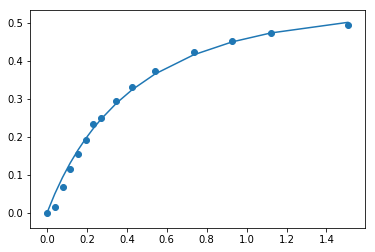

In [21]:
plt.scatter(tbar1,yhat_model1/yc1)
plt.plot(tbar1,res_model1_scaled[0][0,:])

In [22]:
print('Jacobian')
print(*res_model1_scaled[1],sep='\n')

Jacobian
[[0.]]
[[-3.16561338e-05]]
[[-0.00022175]]
[[-0.00066186]]
[[-0.0013968]]
[[-0.00244349]]
[[-0.00379999]]
[[-0.00545538]]
[[-0.00958408]]
[[-0.01464812]]
[[-0.02357401]]
[[-0.04052473]]
[[-0.05820845]]
[[-0.07520724]]
[[-0.10425128]]


In [23]:
S_scaled1,g_scaled1 = pe.Sg_ode(model1_scaled,yhat_model1/yc1,Q1,alpha1,tbar1)
print(S_scaled1)
print(g_scaled1)

0.0025894030218937517
[7.84646492e-07]


## Scaling for parameter estimation
$$\frac{du}{d\bar{t}}=k_1t_cy_c^2(126.2/y_c-u)(91.9/y_c-u)^2-t_ck_2y_cu^2$$
Let $y_c=91.9$ and $t_c=t_\text{end}$,
$$\frac{du}{d\bar{t}}=91.9^2t_\text{end}k_1(126.2/91.9-u)(1-u)^2-91.9t_\text{end}k_2u^2$$
$$\frac{du}{d\bar{t}}=\bar{k}_1(126.2/91.9-u)(1-u)^2-\bar{k}_2u^2$$
where $k_1=\frac{\bar{k}_1}{91.9^2t_\text{end}}$ and $k_2=\frac{\bar{k}_2}{91.9t_\text{end}}$.

In [24]:
def model1_scaled_pe(u,kbar):
    dudt = kbar[0]*(126.2/91.9-u)*(1-u)**2-kbar[1]*u**2
    return dudt

In [25]:
k_guess1 = np.array([1e-6,1e-6])
yc1 = 91.9
tc1 = t_model1[-1]
yhat_bar1 = yhat_model1/yc1
tbar1 = t_model1/tc1
kbar1 = np.empty(2)
kbar1[0] = k_model1[0]*yc1**2*tc1
kbar1[1] = k_model1[1]*yc1*tc1
kbar10 = np.empty(2)
kbar10[0] = k_guess1[0]*yc1**2*tc1
kbar10[1] = k_guess1[1]*yc1*tc1
print(kbar10)

[0.32937879 0.0035841 ]


In [26]:
res_model1_scaled_pe= pe.state_jacob_int(model1_scaled_pe,y0bar1,kbar1,tbar1)

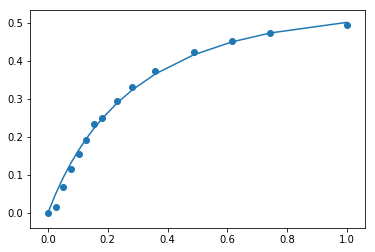

In [27]:
plt.scatter(tbar1,yhat_model1/yc1)
plt.plot(tbar1,res_model1_scaled_pe[0][0,:])

In [28]:
print('Jacobian')
print(*res_model1_scaled_pe[1],sep='\n')

Jacobian
[[0. 0.]]
[[ 3.06368401e-02 -2.09522944e-05]]
[[ 0.05385483 -0.00014713]]
[[ 0.07160716 -0.00043901]]
[[ 0.08525746 -0.00092661]]
[[ 0.09577622 -0.0016208 ]]
[[ 0.10386406 -0.00252077]]
[[ 0.11004802 -0.00361859]]
[[ 0.11821246 -0.00635738]]
[[ 0.12246727 -0.00971647]]
[[ 0.12432792 -0.01563676]]
[[ 0.12122268 -0.02688159]]
[[ 0.11503206 -0.038614  ]]
[[ 0.10818949 -0.04987976]]
[[ 0.09598011 -0.06914894]]


In [29]:
S_scaled1,g_scaled1 = pe.Sg_ode(model1_scaled_pe,yhat_model1/yc1,Q1,kbar1,tbar1)
print(S_scaled1)
print(g_scaled1)

0.0025893368224180016
[-2.68253920e-06 -2.09193598e-07]


In [30]:
g_reduced1 = g_scaled1@np.diag(kbar1)
print(g_reduced1)

[-4.04410683e-06 -2.09635909e-07]


In [31]:
res_model1_scaled_pe0= pe.state_jacob_int(model1_scaled_pe,y0bar1,kbar10,tbar1)

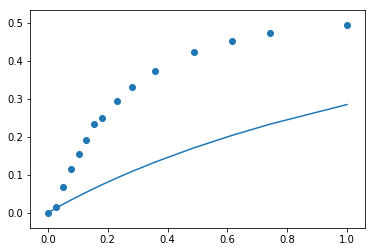

In [32]:
plt.scatter(tbar1,yhat_model1/yc1)
plt.plot(tbar1,res_model1_scaled_pe0[0][0,:])

In [33]:
print('Jacobian')
print(*res_model1_scaled_pe0[1],sep='\n')

Jacobian
[[0. 0.]]
[[ 3.41235144e-02 -1.01532784e-06]]
[[ 6.61892411e-02 -8.67383011e-06]]
[[ 9.63425069e-02 -2.83623794e-05]]
[[ 1.24720572e-01 -6.50680528e-05]]
[[ 1.51455070e-01 -1.23495145e-04]]
[[ 0.17666247 -0.00020761]]
[[ 0.2004411  -0.00032052]]
[[ 0.24409517 -0.00064466]]
[[ 0.28311925 -0.00111679]]
[[ 0.33417027 -0.00213284]]
[[ 0.40310947 -0.00473078]]
[[ 0.45642816 -0.00852831]]
[[ 0.49799093 -0.01355324]]
[[ 0.55617513 -0.02722835]]


In [34]:
S_scaled10,g_scaled10 = pe.Sg_ode(model1_scaled_pe,yhat_model1/yc1,Q1,kbar10,tbar1)
print(S_scaled10)
print(g_scaled10)

0.47500925061657884
[-0.75455613  0.01324812]


In [35]:
g_reduced10 = g_scaled10@np.diag(kbar10)
print(g_reduced10)

[-2.48534785e-01  4.74825852e-05]


## Scaling of model2
\begin{align*}
\frac{dy_1}{dt}=&-k_1\left(y_1^2-y_2\frac{2-2y_1-y_2}{3K_1}\right)-k_2\left(y_1y_2-\frac{(1-y_1-2y_2)(2-2y_1-y_2)}{9K_2}\right);~~y_1(0)=1\\
\frac{dy_2}{dt}=&\frac{k_1}{2}\left(y_1^2-y_2\frac{2-2y_1-y_2}{3K_1}\right)-k_2\left(y_1y_2-\frac{(1-y_1-2y_2)(2-2y_1-y_2)}{9K_2}\right);~~~~y_2(0)=0\\
\end{align*}
Introducing $u_1=\frac{y_1}{M_1},~~u_2=\frac{y_2}{M_2},~~\bar{t}=k_1M_1t$
\begin{align*}
M_1^2k_1\frac{du_1}{d\bar{t}}=&-k_1\left(M_1^2u_1^2-M_2u_2\frac{2-2M_1u_1-M_2u_2}{3K_1}\right)\\
&~~-k_2\left(M_1M_2u_1u_2-\frac{(1-M_1u_1-2M_2u_2)(2-2M_1u_1-M_2u_2)}{9K_2}\right)\\
\frac{du_1}{d\bar{t}}=&-\left(u_1^2-\beta u_2\frac{2/M_1-2u_1-\beta u_2}{3K_1}\right)\\
&~~-\alpha\left(\beta u_1u_2-\frac{(1/M_1-u_1-2\beta u_2)(2/M_1-2u_1-\beta u_2)}{9K_2}\right)\\
M_1M_2k_1\frac{du_2}{d\bar{t}}=&\frac{k_1}{2}\left(M_1^2u_1^2-M_2u_2\frac{2-2M_1u_1-M_2u_2}{3K_1}\right)\\
&~~-k_2\left(M_1M_2u_1u_2-\frac{(1-M_1u_1-2M_2u_2)(2-2M_1u_1-M_2u_2)}{9K_2}\right)\\
\frac{du_2}{d\bar{t}}=&\frac{1}{2}\left(\beta^{-1}u_1^2-u_2\frac{2/M_1-2u_1-\beta u_2}{3K_1}\right)\\
&~~-\alpha\left(u_1u_2-\frac{(1/M_1-u_1-2\beta u_2)(2/M_2-2\beta^{-1}u_1-u_2)}{9K_2}\right)\\
\end{align*}
where $\alpha=\frac{k_2}{k_1}$ and $\beta=\frac{M_2}{M_1}$.

In [36]:
def model2_scaled(u,alpha):
    K1 = 0.242
    K2 = 0.428
    dudt = np.empty(2)
    M1 = 1
    M2 = 0.2
    beta = M2/M1
    r1 = u[0]**2-beta*u[1]*(2/M1-2*u[0]-beta*u[1])/(3*K1)
    r2 = beta*u[0]*u[1]-(1/M1-u[0]-2*beta*u[1])*(2/M1-2*u[0]-beta*u[1])/(9*K2)
    dudt[0] = -r1-alpha*r2
    dudt[1] = r1/(beta*2)-alpha*r2/beta
    return dudt

In [37]:
alpha2 = k_model2[1]/k_model2[0]
tbar2 = k_model2[0]*t_model2
res_model2_scaled = pe.state_jacob_int(model2_scaled,y0_model2,alpha2,tbar2)

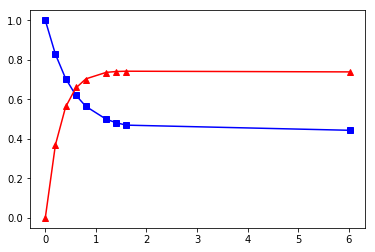

In [38]:
plt.plot(tbar2,yhat_model2[0,:],'bs',tbar2,yhat_model2[1,:]/0.2,'r^')
plt.plot(tbar2,res_model2_scaled[0][0,:],'b',tbar2,res_model2_scaled[0][1,:],'r')

In [39]:
M1 = 1
M2 = 0.2
yhat_bar2 = np.empty((2,9))
yhat_bar2[0] = yhat_model2[0]/M1
yhat_bar2[1] = yhat_model2[1]/M2
Q2 = np.eye(2)

In [40]:
S_scaled2,g_scaled2 = pe.Sg_ode(model2_scaled,yhat_bar2,Q2,alpha2,tbar2)
print(S_scaled2)
print(g_scaled2)

7.654116043872022e-05
[-0.00057352]


In [41]:
print('Jacobian')
print(*res_model2_scaled[1],sep='\n')

Jacobian
[[0.]
 [0.]]
[[-0.00575957]
 [-0.03433398]]
[[-0.01356937]
 [-0.09204756]]
[[-0.01824057]
 [-0.13488666]]
[[-0.01981102]
 [-0.15465307]]
[[-0.01748836]
 [-0.14335525]]
[[-0.01516145]
 [-0.12531464]]
[[-0.01279402]
 [-0.10611978]]
[[-2.03645766e-05]
 [-2.20684400e-04]]


## Scaling for parameter estimation
\begin{align*}
\frac{M_1}{t_c}\frac{du_1}{d\bar{t}}=&-k_1\left(M_1^2u_1^2-M_2u_2\frac{2-2M_1u_1-M_2u_2}{3K_1}\right)\\
&-k_2\left(M_1M_2u_1u_2-\frac{(1-M_1u_1-2M_2u_2)(2-2M_1u_1-M_2u_2)}{9K_2}\right)\\
=&-k_1M_1^2\left(u_1^2-\frac{M_2}{M_1}u_2\frac{\frac{2}{M_1}-2u_1-\frac{M_2}{M_1}u_2}{3K_1}\right)\\
&-k_2M_1^2\left(\frac{M_2}{M_1}u_1u_2-\frac{(\frac{1}{M_1}-u_1-2\frac{M_2}{M_1}u_2)(\frac{2}{M_1}-2u_1-\frac{M_2}{M_1}u_2)}{9K_2}\right)\\
\frac{du_1}{d\bar{t}}=&-k_1M_1t_c\left(u_1^2-\frac{M_2}{M_1}u_2\frac{\frac{2}{M_1}-2u_1-\frac{M_2}{M_1}u_2}{3K_1}\right)\\
&-k_2M_1t_c\left(\frac{M_2}{M_1}u_1u_2-\frac{(\frac{1}{M_1}-u_1-2\frac{M_2}{M_1}u_2)(\frac{2}{M_1}-2u_1-\frac{M_2}{M_1}u_2)}{9K_2}\right)
\end{align*}

\begin{align*}
\frac{M_2}{t_c}\frac{du_2}{d\bar{t}}=&\frac{k_1}{2}\left(M_1^2u_1^2-M_2u_2\frac{2-2M_1u_1-M_2u_2}{3K_1}\right)\\
&-k_2\left(M_1M_2u_1u_2-\frac{(1-M_1u_1-2M_2u_2)(2-2M_1u_1-M_2u_2)}{9K_2}\right)\\
=&\frac{k_1M_1^2}{2}\left(u_1^2-\frac{M_2}{M_1}u_2\frac{\frac{2}{M_1}-2u_1-\frac{M_2}{M_1}u_2}{3K_1}\right)\\
&-k_2M_1^2\left(\frac{M_2}{M_1}u_1u_2-\frac{(\frac{1}{M_1}-u_1-2\frac{M_2}{M_1}u_2)(\frac{2}{M_1}-2u_1-\frac{M_2}{M_1}u_2)}{9K_2}\right)\\
\frac{du_2}{d\bar{t}}=&\frac{k_1M_1t_c}{2}\frac{M_1}{M_2}\left(u_1^2-\frac{M_2}{M_1}u_2\frac{\frac{2}{M_1}-2u_1-\frac{M_2}{M_1}u_2}{3K_1}\right)\\
&-k_2M_1t_c\frac{M_1}{M_2}\left(\frac{M_2}{M_1}u_1u_2-\frac{(\frac{1}{M_1}-u_1-2\frac{M_2}{M_1}u_2)(\frac{2}{M_1}-2u_1-\frac{M_2}{M_1}u_2)}{9K_2}\right)
\end{align*}

Let $M_1=M_2=M$ and $t_c=t_\text{end}$,
\begin{align*}
\frac{du_1}{d\bar{t}}=&-\bar{k}_1\left(u_1^2-u_2\frac{\frac{2}{M}-2u_1-u_2}{3K_1}\right)\\
&-\bar{k}_2\left(u_1u_2-\frac{(\frac{1}{M}-u_1-2u_2)(\frac{2}{M}-2u_1-u_2)}{9K_2}\right)
\end{align*}
\begin{align*}
\frac{du_2}{d\bar{t}}=&\frac{\bar{k}_1}{2}\left(u_1^2-u_2\frac{\frac{2}{M}-2u_1-u_2}{3K_1}\right)\\
&-\bar{k}_2\left(u_1u_2-\frac{(\frac{1}{M}-u_1-2u_2)(\frac{2}{M}-2u_1-u_2)}{9K_2}\right)
\end{align*}
where $k_1=\frac{\bar{k}_1}{Mt_\text{end}}$ and $k_2=\frac{\bar{k}_2}{Mt_\text{end}}$.

In [42]:
def model2_scaled_pe(u,kbar):
    K1 = 0.242
    K2 = 0.428
    M = 1
    r1 = kbar[0]*(u[0]**2-u[1]*(2/M-2*u[0]-u[1])/(3*K1))
    r2 = kbar[1]*(u[0]*u[1]-(1/M-u[0]-2*u[1])*(2/M-2*u[0]-u[1])/(9*K2))
    dudt = np.empty(2)
    dudt[0] = -r1-r2
    dudt[1] = r1/2-r2
    return dudt

In [43]:
k20 = np.array([1e4,1e4])
M = 1.0
yhat_bar2 = yhat_model2/M
y0bar2 = yhat_bar2[:,0]
tc2 = t_model2[-1]
tbar2 = t_model2/tc2
kbar2 = np.empty(2)
kbar2[0] = k_model2[0]*M*tc2
kbar2[1] = k_model2[1]*M*tc2
kbar20 = np.empty(2)
kbar20[0] = k20[0]*(M*tc2)
kbar20[1] = k20[1]*(M*tc2)
print(kbar20)

[169.69999298 169.69999298]


In [44]:
res_model2_scaled_pe= pe.state_jacob_int(model2_scaled_pe,y0bar2,kbar2,tbar2)

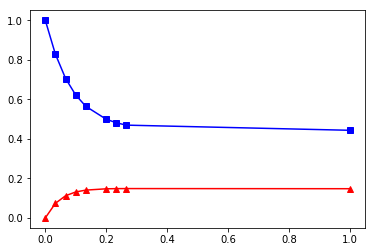

In [45]:
plt.plot(tbar2,yhat_bar2[0,:],'bs',tbar2,yhat_bar2[1,:],'r^')
plt.plot(tbar2,res_model2_scaled_pe[0][0,:],'b',tbar2,res_model2_scaled_pe[0][1,:],'r')

In [46]:
print('Jacobian')
print(*res_model2_scaled_pe[1],sep='\n')

Jacobian
[[0. 0.]
 [0. 0.]]
[[-0.02299987 -0.00095702]
 [ 0.00998918 -0.00114103]]
[[-0.03103604 -0.00225477]
 [ 0.01228567 -0.00305904]]
[[-0.03096979 -0.00303101]
 [ 0.01162685 -0.00448239]]
[[-0.02740395 -0.00329238]
 [ 0.01004713 -0.00513979]]
[[-0.01812099 -0.00290635]
 [ 0.00669142 -0.00476428]]
[[-0.01407999 -0.00251985]
 [ 0.00529579 -0.00416511]]
[[-0.01084503 -0.00212588]
 [ 0.00417    -0.00352608]]
[[-7.41415510e-06 -3.38694059e-06]
 [ 4.44880820e-06 -7.33706364e-06]]


In [47]:
S_scaled2,g_scaled2 = pe.Sg_ode(model2_scaled_pe,yhat_bar2,Q2,kbar2,tbar2)
print(S_scaled2)
print(g_scaled2)

7.051009882562633e-06
[5.32582329e-07 3.66306911e-08]


In [48]:
g_reduced2 = g_scaled2@np.diag(kbar2)
print(g_reduced2)

[3.20493743e-06 2.48792094e-07]


In [49]:
res_model2_scaled_pe0= pe.state_jacob_int(model2_scaled_pe,y0bar2,kbar20,tbar2)

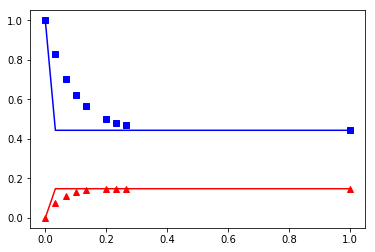

In [50]:
plt.plot(tbar2,yhat_bar2[0,:],'bs',tbar2,yhat_bar2[1,:],'r^')
plt.plot(tbar2,res_model2_scaled_pe0[0][0,:],'b',tbar2,res_model2_scaled_pe0[0][1,:],'r')

In [51]:
print('Jacobian')
print(*res_model2_scaled_pe0[1],sep='\n')

Jacobian
[[0. 0.]
 [0. 0.]]
[[-4.38236014e-07 -7.88192754e-07]
 [ 2.19120901e-07 -1.29974882e-06]]
[[ 4.89706450e-10  6.40922748e-10]
 [-2.32276129e-10  1.09202552e-09]]
[[-6.80755065e-11 -9.65273604e-11]
 [ 2.88830072e-11 -3.18692351e-10]]
[[ 5.46895495e-11  6.23940348e-11]
 [-2.33607529e-11  2.18315751e-10]]
[[-2.61679587e-11  2.82837751e-11]
 [ 5.98140432e-12 -1.30885301e-10]]
[[-3.88541674e-13  7.26346019e-11]
 [-6.73578764e-12 -4.37529818e-11]]
[[-2.49307383e-13  4.59197942e-11]
 [-4.27221023e-12 -2.77239407e-11]]
[[ 2.80946635e-12  3.77180756e-11]
 [-4.26672754e-12 -4.85938845e-12]]


In [52]:
S_scaled20,g_scaled20 = pe.Sg_ode(model2_scaled_pe,yhat_bar2,Q2,kbar20,tbar2)
print(S_scaled20)
print(g_scaled20)

0.27500813434344207
[1.84682353e-07 2.06821488e-07]


In [53]:
g_reduced20 = g_scaled20@np.diag(kbar20)
print(g_reduced20)

[3.1340594e-05 3.5097605e-05]


### Reduced Jacobian
Reduced parameter sensitivity matrix $\mathbf{J}_\text{R}$ is
$$\mathbf{J}_\text{R}=\mathbf{JK}$$
where $\mathbf{K}=\text{diag}(k_1,\cdots,k_p)$

In [54]:
K2 = np.diag(kbar2)
JR2 = res_model2_scaled_pe[1]@K2
print(JR2)

[[[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 [[-1.38407046e-01 -6.49996122e-03]
  [ 6.01121928e-02 -7.74974246e-03]]

 [[-1.86766528e-01 -1.53141562e-02]
  [ 7.39318554e-02 -2.07766695e-02]]

 [[-1.86367852e-01 -2.05863151e-02]
  [ 6.99672891e-02 -3.04439858e-02]]

 [[-1.64909612e-01 -2.23615569e-02]
  [ 6.04609526e-02 -3.49089330e-02]]

 [[-1.09047226e-01 -1.97396515e-02]
  [ 4.02671689e-02 -3.23585114e-02]]

 [[-8.47296091e-02 -1.71145835e-02]
  [ 3.18686135e-02 -2.82890043e-02]]

 [[-6.52625002e-02 -1.44387478e-02]
  [ 2.50939647e-02 -2.39488130e-02]]

 [[-4.46163943e-05 -2.30037713e-05]
  [ 2.67717330e-05 -4.98326232e-05]]]


In [55]:
K20 = np.diag(kbar20)
JR20 = res_model2_scaled_pe0[1]@K2
print(JR20)

[[[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 [[-2.63718664e-06 -5.35332859e-06]
  [ 1.31861074e-06 -8.82776765e-06]]

 [[ 2.94692190e-09  4.35308502e-09]
  [-1.39777537e-09  7.41693124e-09]]

 [[-4.09660117e-10 -6.55604451e-10]
  [ 1.73810181e-10 -2.16452748e-09]]

 [[ 3.29107022e-10  4.23774221e-10]
  [-1.40578738e-10  1.48277936e-09]]

 [[-1.57471748e-10  1.92100652e-10]
  [ 3.59944849e-11 -8.88960246e-10]]

 [[-2.33813945e-12  4.93327158e-10]
  [-4.05341612e-11 -2.97166001e-10]]

 [[-1.50026488e-12  3.11882779e-10]
  [-2.57090139e-11 -1.88298311e-10]]

 [[ 1.69066140e-11  2.56177504e-10]
  [-2.56760205e-11 -3.30044941e-11]]]


# Parameter estimation with Levenberg-Marquardt method
## Model 1 

In [56]:
pe1 = pe.lm(model1_scaled_pe,yhat_bar1,Q1,kbar10,tbar1)

Iteration | Evaluation | Objective function | Reduced gradient | mu
         0	         1		   4.75e-01		   2.49e-01		  1.30e-03
         1	         2		   5.74e-02		   1.19e-01		  4.35e-04
         2	         3		   1.17e-02		   1.88e-02		  1.45e-04
         3	         4		   1.07e-02		   9.06e-04		  4.83e-05
         4	         5		   1.06e-02		   8.49e-05		  1.61e-05
         5	         6		   9.76e-03		   4.74e-04		  5.37e-06
         6	         7		   2.91e-03		   1.10e-03		  1.79e-06
         7	         8		   2.59e-03		   1.60e-04		  5.96e-07
         8	         9		   2.59e-03		   4.19e-06		  1.99e-07
         9	        10		   2.59e-03		   3.72e-07		  6.63e-08


In [57]:
print(*pe1,sep='\n')

[1.50760173 1.00221855]
[[0.         0.04950383 0.09275549 0.13086482 0.16468117 0.19486079
  0.2219443  0.24634362 0.28844777 0.32330318 0.36527425 0.41564529
  0.44972035 0.47320413 0.50118002]]
[10, 9]


In [58]:
print(kbar1)

[1.50756672 1.00211436]


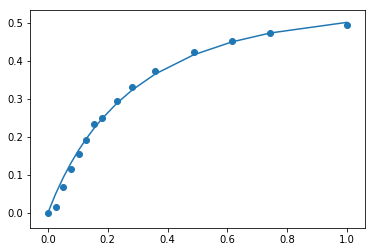

In [59]:
plt.scatter(tbar1,yhat_model1/yc1)
plt.plot(tbar1,pe1[1][0,:])

In [60]:
pe2 = pe.lm(model2_scaled_pe,yhat_bar2,Q2,kbar2,tbar2)

Iteration | Evaluation | Objective function | Reduced gradient | mu
         0	         1		   7.05e-06		   3.20e-06		  4.42e-06


In [61]:
print(pe2)

[array([6.01773145, 6.79190282]), array([[1.        , 0.82833156, 0.70540696, 0.62146441, 0.56432376,
        0.49898239, 0.48109735, 0.4693448 , 0.443299  ],
       [0.        , 0.07379222, 0.11221304, 0.13131486, 0.14069828,
        0.14727322, 0.1481463 , 0.14843863, 0.14773838]]), [8, 8]]
